# Adapted from tutorial nemo 3

In [21]:
import datetime
import pathlib

import parcels
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4_3D

from parcels import logger, XarrayDecodedFilter

logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

# Subset, lower left corner of my grid
enatl_data_path = pathlib.Path("day_1_5")

u_files = sorted(enatl_data_path.glob("*1d_vozocrtx*"))
v_files = sorted(enatl_data_path.glob("*1d_vomecrty*"))
w_files = sorted(enatl_data_path.glob("*1d_vovecrtz*"))

assert len(u_files) == len(w_files)
assert len(u_files) == len(v_files)

enatl_mesh_mask_file = enatl_data_path / "mesh_mask_eNATL60FARSHE_3.6.nc"

The given data files are on u-, v, and, w-points respectively. The data is output from a nemo 3.6 model run, [[https://github.com/ocean-next/eNATL60]]

According to the [[NEMO 3D tutorial|https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_nemo_3D.ipynb]], the f-points should be given.

In [8]:
filenames_as_in_tutorial = {
    "U": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": u_files,
    },
    "V": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": v_files,
    },
    "W": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": w_files,
    },
}

variables = {
    "U": "vozocrtx",
    "V": "vomecrty",
    "W": "vovecrtz",
}

dimensions_as_in_tutorial = {
    "U": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "V": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "W": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
}

In [9]:
fieldset_as_in_tutorial = FieldSet.from_nemo(
    filenames_as_in_tutorial, variables, dimensions_as_in_tutorial
)

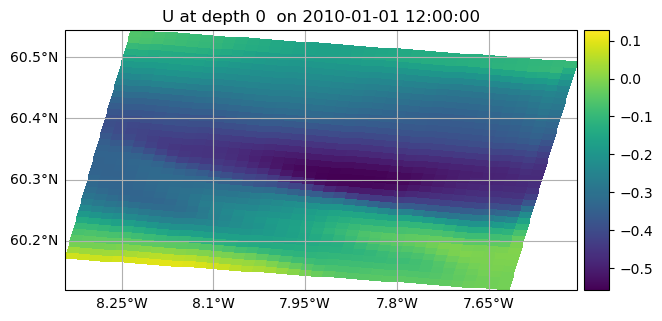

In [10]:
fieldset_as_in_tutorial.U.show()

But also, from the documentation string from ``parcels.FieldSet.from_c_grid_dataset

       To interpolate U, V velocities on the C-grid, Parcels needs to read the f-nodes,
       which are located on the corners of the cells.
       (for indexing details: https://www.nemo-ocean.eu/doc/img360.png )
       In 3D, the depth is the one corresponding to W nodes.

# Question
So, if I already have my variables o the fieldset, why don't I do the following?

In [5]:
filenames_assuming_c_grid = {
    "U": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": u_files[0],
        "data": u_files,
    },
    "V": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": v_files[0],
        "data": v_files,
    },
    "W": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": w_files,
    },
}

variables = {
    "U": "vozocrtx",
    "V": "vomecrty",
    "W": "vovecrtz",
}

dimensions_assuming_c_grid = {
    "U": {"lon": "glamu", "lat": "gphiu", "depth": "depthu", "time": "time_counter"},
    "V": {"lon": "glamv", "lat": "gphiv", "depth": "depthv", "time": "time_counter"},
    "W": {"lon": "glamw", "lat": "gphiw", "depth": "depthw", "time": "time_counter"},
}

In [6]:
fieldset_c_grid_points = FieldSet.from_nemo(
    filenames_assuming_c_grid, variables, dimensions_assuming_c_grid
)

ValueError: On a C-grid, the dimensions of velocities should be the corners (f-points) of the cells, so the same for U and V. See also https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb

Now I want to add temperature and salinity. In the [[NEMO 3D tutorial|https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_nemo_3D.ipynb]], they exemplify this by adding scale factor. They are given on the t-points. Why should these variables be given on their t-points and not on the f-points?

In [11]:
vosalinity_files = sorted(enatl_data_path.glob("*1d_vosaline*"))
votemper_files = sorted(enatl_data_path.glob("*1d_votemper*"))

# regardless of naming,
dimensions_t_points = dict(
    lon="nav_lon", lat="nav_lat", depth="deptht", time="time_counter"
)

vosalinity = Field.from_netcdf(vosalinity_files, ("S", "vosaline"), dimensions_t_points)
votemper = Field.from_netcdf(votemper_files, ("T", "votemper"), dimensions_t_points)

In [12]:
# In case I happened to run a parcel execute I reinitialise fildset_as_in_tutorial
fieldset_as_in_tutorial = FieldSet.from_nemo(
    filenames_as_in_tutorial, variables, dimensions_as_in_tutorial
)

In [13]:
fieldset_as_in_tutorial.add_field(vosalinity)
fieldset_as_in_tutorial.add_field(votemper)

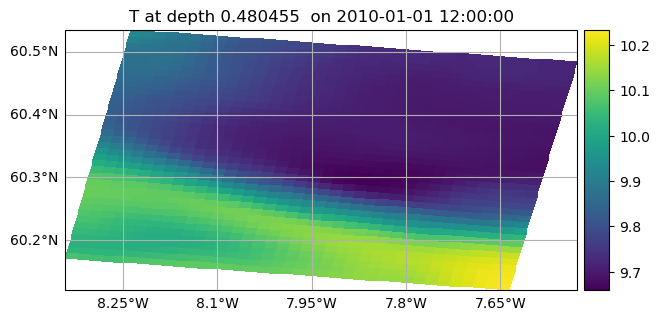

In [14]:
fieldset_as_in_tutorial.T.show()

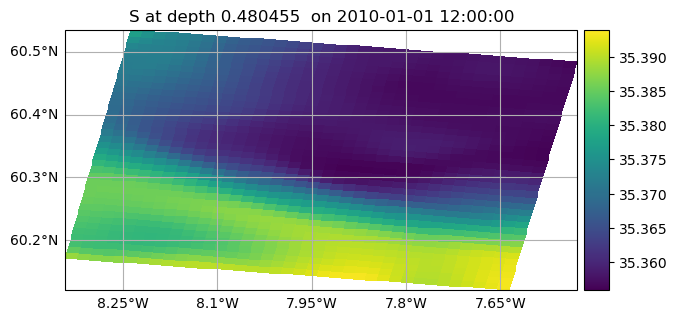

In [15]:
fieldset_as_in_tutorial.S.show()

In [17]:
start_point = (-7.883789, 60.239120)  # y_c = 9, x_r = 21
stop_point = (-7.857898, 60.327419)  # y_c = 18, x_r = 21
depth = 52.48403405  # z_c = 20

pset = ParticleSet.from_line(
    fieldset=fieldset_as_in_tutorial,
    pclass=JITParticle,
    size=10,
    start=start_point,
    finish=stop_point,
    depth=depth,
)
kernels = pset.Kernel(AdvectionRK4_3D)

In [18]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [22]:
output_file = pset.ParticleFile(
    name="output_uvw.zarr", outputdt=datetime.timedelta(hours=6)
)
starttime = datetime.datetime(2010, 1, 1, 12)
endtime = starttime + datetime.timedelta(days=4)
runtime = endtime - starttime

pset.execute(
    kernels,
    runtime=runtime,
    dt=datetime.timedelta(hours=6),
    output_file=output_file,
    recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/libee66b0c02f9b2e1790b1afb189c3c66c_0.so


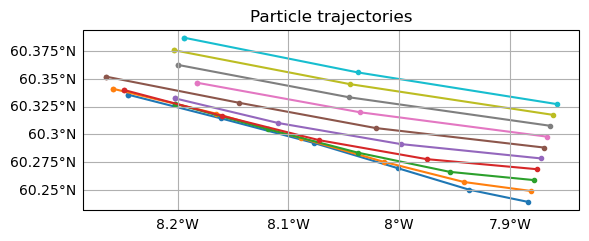

<module 'matplotlib.pyplot' from '/Users/niten/.local/anaconda/envs/opt-m1-lagrangian/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [24]:
parcels.plotTrajectoriesFile("output_uvw.zarr")